### Processing and dowloading Sentine-2 10 m bands using the Data Cube Chile platform
https://datacubechile.cl/

In [ ]:
%matplotlib inline

import datacube
import pandas as pd
from odc.ui import DcViewer
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as rio
import numpy as np

from datacube.utils import masking
from datacube.utils.rio import configure_s3_access
configure_s3_access(aws_unsigned=False, requester_pays=True)

In [14]:
dc = datacube.Datacube(app='mangles')

In [2]:
shp = gpd.read_file('Mangles/ClasVisual_042023.shp')
shp

/env/lib/python3.10/site-packages/pygeos/io.py:89: UserWarning: The shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the PyGEOS GEOS version (3.10.2-CAPI-1.16.0). Conversions between both will be slow
  warnings.warn(


,OBJECTID,Name,Code,Shape_Leng,Shape_Area,geometry
0,1,1 ParB,3,1904.002190,42754.872071,"POLYGON ((559679.438 888813.491, 559680.232 88..."
1,2,1 ParB,4,1780.842289,131007.732503,"POLYGON ((559679.438 888813.491, 559280.284 88..."
2,3,1 ParB,16,1525.451701,76237.395426,"POLYGON ((559780.284 888847.537, 559771.831 88..."
3,4,10 ParB,1,1741.281341,147916.131599,"POLYGON ((572700.402 919661.934, 572701.952 91..."
4,5,10 ParB,5,2472.043165,40912.174507,"MULTIPOLYGON (((572609.894 919661.934, 572600...."
...,...,...,...,...,...,...
188,190,Anexo 8,16,639.818516,6931.458661,"MULTIPOLYGON (((568244.425 922492.041, 568208...."
189,191,Anexo 8,20,1698.600182,31146.568475,"POLYGON ((568684.797 922631.520, 568684.797 92..."
190,192,Anexo 9,2,1729.557193,49142.763716,"POLYGON ((567341.953 922277.345, 567124.818 92..."
191,193,Anexo 9,4,933.681396,22086.093936,"MULTIPOLYGON (((567193.220 922665.429, 567174...."


In [3]:
sitios = shp.Name.unique()
sitios

array(['1 ParB', '10 ParB', '11 ParB', '12 ParB', '13 ParB', '14 ParB',
       '15 ParB a', '15 ParB b', '17 ParB', '18 ParB', '19 ParB',
       '2 ParB', '20 ParB', '21 ParB a', '21 ParBb', '3 ParB', '4 ParB',
       '5 ParB', '6 ParB', '7 ParB', '8 ParB', '9 ParB', 'Anexo 1',
       'Anexo 10', 'Anexo 11', 'Anexo 12', 'Anexo 13', 'Anexo 14',
       'Anexo 15', 'Anexo 16', 'Anexo 18', 'Anexo 19', 'Anexo 2',
       'Anexo 20', 'Anexo 3', 'Anexo 4', 'Anexo 5', 'Anexo 6', 'Anexo 7',
       'Anexo 8', 'Anexo 9'], dtype=object)

In [4]:
# remove Anexo 15 from list
sitios = [x for x in sitios if x != 'Anexo 15']
sitios

['1 ParB',
 '10 ParB',
 '11 ParB',
 '12 ParB',
 '13 ParB',
 '14 ParB',
 '15 ParB a',
 '15 ParB b',
 '17 ParB',
 '18 ParB',
 '19 ParB',
 '2 ParB',
 '20 ParB',
 '21 ParB a',
 '21 ParBb',
 '3 ParB',
 '4 ParB',
 '5 ParB',
 '6 ParB',
 '7 ParB',
 '8 ParB',
 '9 ParB',
 'Anexo 1',
 'Anexo 10',
 'Anexo 11',
 'Anexo 12',
 'Anexo 13',
 'Anexo 14',
 'Anexo 16',
 'Anexo 18',
 'Anexo 19',
 'Anexo 2',
 'Anexo 20',
 'Anexo 3',
 'Anexo 4',
 'Anexo 5',
 'Anexo 6',
 'Anexo 7',
 'Anexo 8',
 'Anexo 9']

In [64]:
product = "s2_l2a"
bands = ["B02", "B03", "B04", "B08", "SCL"]

sr_bands = bands.copy()
sr_bands.remove("SCL")

In [74]:
def cloudMask(img):
    from odc.algo import keep_good_only, geomedian_with_mads, to_f32
    
    
    fmask_band = "SCL"
    good_pixel_flags = [
        "vegetation",
        "snow or ice",
        "water",
        "bare soils",
        "unclassified",
        "dark area pixels",
    ]

    flags = (
        dc.list_measurements()
        .loc[product]
        .loc[fmask_band]["flags_definition"]["qa"]["values"]
    )

    pq_mask = img[fmask_band].isin([int(k) for k, v in flags.items() if v in good_pixel_flags])

    data = keep_good_only(img[sr_bands], where=pq_mask)

    scale, offset = (1/10_000, 0)
    return to_f32(data, scale=scale, offset=offset)

In [76]:
# test on one area
site = sitios[0]
sitio_id = shp.where(shp.Name == site)#.dropna()
# dissolve the polygons
diss_id = sitio_id.dissolve(by='Name')


img = dc.load(product=product,
      measurements=bands,
      x=(diss_id.bounds.values[0][0], diss_id.bounds.values[0][2]),
      y=(diss_id.bounds.values[0][1], diss_id.bounds.values[0][3]),
      crs = 'EPSG:32617',
      output_crs = 'EPSG:32617', 
      time = ("2023-01-01", "2023-03-01"),
      resolution = (-10, 10),
      dask_chunks={"time": 1}
      )

img = cloudMask(img)

In [87]:
# any NAN? 
def isNan(img):
    import xarray as xr
    # Check for non-NaN values across all dimensions except 'time'
    non_nan_mask = img.notnull().all(dim=('x', 'y'))
    # Get the indices of 'time' dimension where there are no NaN values
    return non_nan_mask.where(non_nan_mask).dropna(dim='time')['time'].values

non_nan_time_indices = isNan(img)

In [89]:
non_nan_time_indices

array(['2023-01-02T16:01:07.000000000', '2023-01-07T16:01:05.000000000',
       '2023-01-12T16:01:05.000000000', '2023-01-17T16:01:05.000000000',
       '2023-01-22T16:01:04.000000000', '2023-01-27T16:01:05.000000000',
       '2023-02-06T16:01:06.000000000', '2023-02-11T16:01:06.000000000',
       '2023-02-21T16:01:05.000000000', '2023-02-26T16:01:08.000000000'],
      dtype='datetime64[ns]')

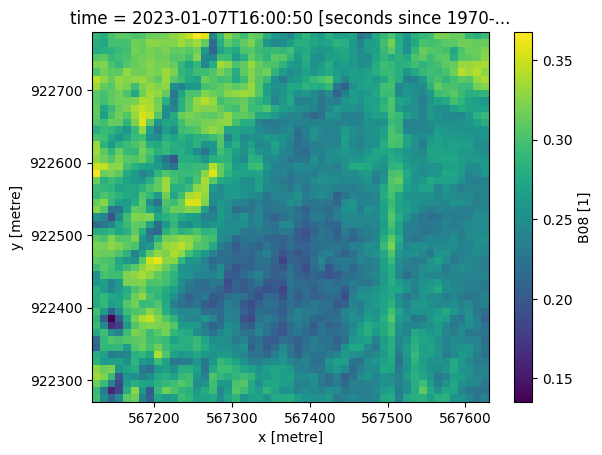

In [107]:
img.sel(time=non_nan_time_indices[0]).B08.plot()

In [91]:
# all in a loop

for site in sitios:
    sitio_id = shp.where(shp.Name == site)#.dropna()
    # dissolve the polygons
    diss_id = sitio_id.dissolve(by='Name')
    
    img = dc.load(product=product,
          measurements=bands,
          x=(diss_id.bounds.values[0][0], diss_id.bounds.values[0][2]),
          y=(diss_id.bounds.values[0][1], diss_id.bounds.values[0][3]),
          crs = 'EPSG:32617',
          output_crs = 'EPSG:32617', 
          time = ("2023-01-01", "2023-03-01"),
          resolution = (-10, 10),
          dask_chunks={"time": 1}
          )
    img = cloudMask(img)
    
    non_nan_time_indices = isNan(img)
    
    out = img.sel(time=non_nan_time_indices[0])
    
    out.attrs.pop('grid_mapping', None)  # Add this line to remove the 'grid_mapping' key
    out.rio.to_raster('Mangles/tiles_S2/' + site + '.tif')

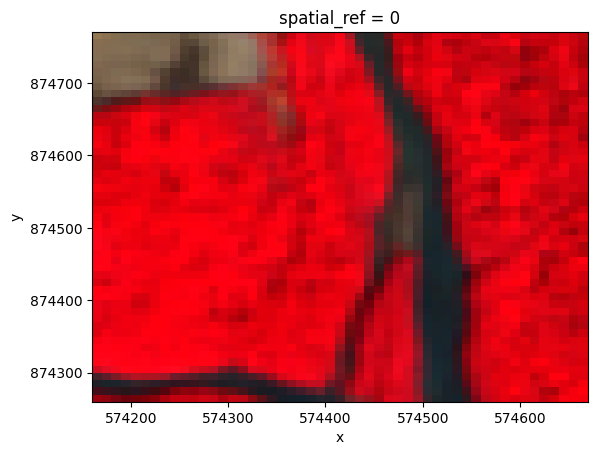

In [105]:
# test outputs
rio.open_rasterio('Mangles/tiles_S2/' + sitios[20] + '.tif').isel(band=[3,2,1]).plot.imshow(robust=True)
